<center><font size = "10"> Week 8 - Synapses <center>
<center><font size = "8">Home work - Solutions<center>

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 1
<br>Group member1: Gasser
<br>Group member2: Louise
<br>Group member3: Milo

In [1]:
!nrnivmodl 

x86_64-w64-mingw32-gcc -DDLL_EXPORT -DPIC -I/cygdrive/c/nrn/bin//../src/scopmath -I/cygdrive/c/nrn/bin//../src/nrnoc -I/cygdrive/c/nrn/bin//../src/oc  -c mod_func.c
x86_64-w64-mingw32-gcc  -shared mod_func.o SimpleAMPA_NMDA.o TsodyksMarkram_AMPA_NMDA.o vecevent.o \
  -L/cygdrive/c/nrn/bin//../bin -lnrniv -lpthread -o 917.nrnmech.dll
#rebase -b 0x64000000 -v nrnmech.dll

nrnmech.dll was built successfully.


In [42]:
#Import packages
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt
import h5py
%matplotlib inline

# Load external files & initialize
h.load_file("stdrun.hoc");
h.stdinit();

## Ex1. Plot the dependence of the NMDA conductance on Mg<sup>2+</sup>.

<font sie='3'>Create a single compartmental soma neuron to host the synpase modeled in SimpleAMPA_NMDA.mod file. Using the stimulation pattern and the values for the peak synaptic conductances used in tutorial 01, plot the NMDA conductance after removing the magnesium block, without changing the Mg<sup>2+</sup> concentration. Show how the NMDA conductance changes as the magnesium block is gradually removed.
    
<font sie='3'>Explain what happens to the NMDA conductance and why, in a mechanistic sense, does this happen. What could be the functional purpose of this behavior? [1.5 pts]

In [37]:
# Build Soma compartment
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1
    
# Create a synapse
synapse = h.SimpleAMPA_NMDA(soma(0.5))

# Define stimulus
stimulator = h.VecStim()
spike_fast = np.arange(100,950,5)
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

# Build Recording Electrodes
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

# Set synapses conductances (AMPA & NMDA)
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)

h.tstop = 1100.0 # ms
h.run()

0.0

In [38]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = np.array(t)
    time_to_peak = (tau_r*tau_d)/(tau_d-tau_r)*np.log(tau_d/tau_r)
    factor = -np.exp(-time_to_peak/tau_r)+np.exp(-time_to_peak/tau_d)
    f_dual_exp = lambda t: (np.exp(-t/tau_d) - np.exp(-t/tau_r))/factor
    dual_exp = np.zeros_like(t)
    dual_exp[t>=t_start] = f_dual_exp(t[t>=t_start]-t_start)
    return dual_exp

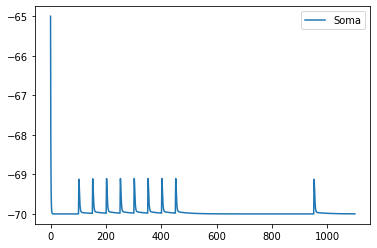

In [39]:
plt.figure()
plt.plot(time, v_soma, label='Soma')
plt.legend()

(80.0, 1100.0, 0.0, 0.0011)

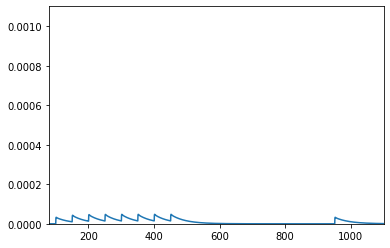

In [40]:
plt.figure()
# plt.plot(time, g_syn, label='g')
plt.plot(time, g_NMDA, label= 'g_NMDA')
# plt.plot(time, g_AMPA, label = 'g_AMPA')
plt.axis([80.0, 1100.0, 0.0, 0.0011])

### Conclusion:

Current flow through NMDAR channels is largely blocked by external Mg2+ ions at resting membrane potentials, but can be relieved by depolarization. NMDARs receptors play a key role in the induction of many forms of synaptic plasticity. As NMDARs are largely blocked by Mg2+ at resting membrane potentials, the kinetics of Mg2+ unblock of NMDAR channels will influence NMDAR activation during synaptic plasticity induction. This is likely to be particularly important during spike-timing dependent plasticity (STDP), where the coincidence of EPSPs and action potentials (APs) within a brief time window determines the magnitude and sign of changes in synaptic strength.

## Ex2. Configure a pseudolinear synapse (E3)

<font size='3'> Create a single compartmental soma neuron, add to it passive properties, add to the center of the neuron a synapse with the mechanism modeled in TsodyksMarkram_AMPA_NMDA.mod file, inject a stimulation pattern and define the conductances for NMDA and AMPA receptors, as it was done in tutorial 02. 

<font size='3'>Find the values for U1, tau_rec and tau_facil that would make the synapse behave as a pseudolinear synapse and plot the R, Use and conductance curves.
    
<font size='3'>Define U1, tau_rec and tau_facil. Would you be able to define any relation between these variables depending on the synapse type? If yes, please explain. [1.5 pts]    

In [41]:
# Build Soma compartment
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert('pas')

# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1
    
# Create a synapse
synapse = h.SimpleAMPA_NMDA(soma(0.5))

# Define stimulus
stimulator = h.VecStim()
spike_fast = np.arange(100,950,5)
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0        # In units of [nS] due to the gmax scaling factor in our .mod file

# Build Recording Electrodes
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

# Set synapses conductances (AMPA & NMDA)
synapse.gmax_AMPA = 0.001 # uS
synapse.gmax_NMDA = 0.7 * 0.001 # uS - 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1 # mM
g_NMDA = h.Vector()
g_NMDA.record(synapse._ref_g_NMDA)
g_AMPA = h.Vector()
g_AMPA.record(synapse._ref_g_AMPA)

h.tstop = 1000.0 # ms
h.run()

AttributeError: 'hoc.HocObject' object has no attribute '_ref_R'

In [ ]:
synapse.U1 = ?? # Baseline release probability
synapse.tau_rec = ?? # ms - recovery from depression
synapse.tau_facil = ?? # ms - relaxation from facilitation

# Ex 3. Ornstein-Uhlenbeck Process

<font size='3'> Based on the data from one of connections in your group folder (.h5 files), calculate the parameters reuqired for an Ornstein-Uhlenbeck process, and plot their distributions as shown in [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928). Note that you don't need to plot the smoothed histogram overlay shown in the paper [1.5 pts]


In [56]:
data1 = h5py.File('connection_c1.h5', 'r')
data2 = h5py.File('connection_c2.h5', 'r')
data3 = h5py.File('connection_c4.h5', 'r')

print(data.keys())

<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


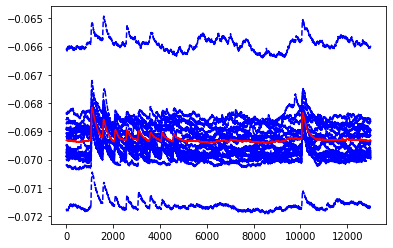

In [50]:
# Create an array with the data

connection_array = []
for v in data.keys():
    dat = data.get(v)
    dat = np.array(dat)
    connection_array.append(dat)

mean_trace = np.mean(connection_array, axis = 0)

plt.figure()
for rep in connection_array:
    plt.plot(rep, 'b--')
plt.plot(mean_trace, 'r')


In [51]:
def amp_rise_lat_firstEPSP(sample_connection, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = False):
    """
    This function selects the rise curve (first EPSP) and find the  5, 20 and 80 % of the amplitude.
    Firstly computes the amplitude as the difference minimum - maximum in the interval (first_stimulus, max_peak).
    Secondly computes the percentages and find the times for these respective values.
    Tau_rise = 80%_time - 20%_time (Feldmeyer et al., 1999)
    latency = 5%_time - first_stimulus
    :param sample_connection: array with voltage traces oriented (voltage vs trials)(row vs column)
    :param STIM_TIMES: list with the stimuli points
    :param time: list with time steps in s
    :param t_wind_aft: time window after the stim time to compute max and min
    :param t_wind_bef: time window before the stim time to compute max and min
    :return amp_value: amplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    :return TAU_rise: list with tau_rise values in ms. Computed as the distance between the times when
    the 20 and 80 % of the rise part for the first EPSP happens
    :return latency: list with latency values in ms. Computed as the time between the AP of the presynaptic cell
    and the 5% of the first EPSP
    """
    # The analysis are performed over the mean trace
    conn = np.mean(sample_connection, axis=0)

    # save only the trace part for the first peak for voltage and time
    rise_curve = conn[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]
    rise_curve_time = time[STIM_TIMES[0] - t_wind_bef:STIM_TIMES[0] + t_wind_aft]

    # find max, min and compute amplitude
    max_value = np.max(rise_curve)
    min_value = np.min(rise_curve)
    amp_value_total = np.abs(max_value - min_value)

    # compute percentages
    twenty_peak_value = amp_value_total * 80.0 / 100.0
    eighty_peak_value = amp_value_total * 20.0 / 100.0
    five_peak_value = amp_value_total * 95.0 / 100.0
    amp_value = eighty_peak_value - twenty_peak_value

    # Find the exact voltage point
    twenty_curve_value = -(twenty_peak_value - max_value)
    eighty_curve_value = -(eighty_peak_value - max_value)
    five_curve_value = -(five_peak_value - max_value)

    # Find time point for the minimum
    for x, s in zip(rise_curve, rise_curve_time):
        if (x == min_value):
            min_time = s

    # Find time points for the 5, 20 and 80 % of the first EPSP
    n = 0
    m = 0
    l = 0
    for i, j in zip(rise_curve, rise_curve_time):
        if (n == 0) and (i > twenty_curve_value) and (j > min_time):
            twenty_time = j
            n = 1
        if (m == 0) and (i > eighty_curve_value) and (j > min_time):
            eighty_time = j
            m = 1
        if (l == 0) and (i > five_curve_value) and (j > min_time):
            five_time = j
            l = 1
    
    pre_AP = time[STIM_TIMES[0]]
    TAU_rise = np.abs((twenty_time-eighty_time))
    latency = np.abs((five_time)-pre_AP)

    # PLOT first EPSP with the computed points for the 5, 20 and 80 % of the first EPSP
    if PLOT == True:
        plt.figure()
        plt.plot(rise_curve_time, rise_curve, label='first EPSP')
        plt.plot(twenty_time, twenty_curve_value, 'ro', label='20%')
        plt.plot(eighty_time, eighty_curve_value, 'mo', label='80%')
        plt.plot(five_time, five_curve_value, 'go', label='5%')
        plt.legend()
        plt.show()

    return amp_value, TAU_rise, latency

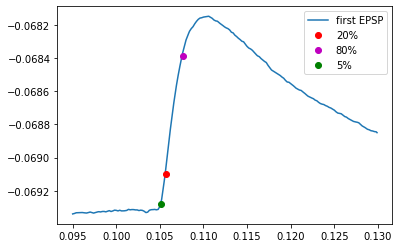

Amplitude =  -0.7139286824635049 mV
Tau_rise =  0.001899999999999999 s
latency =  0.005099999999999993 s


In [52]:
# times where a stimulus is performed
STIM_TIMES = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000]
t_wind_aft = 300
t_wind_bef = 50
time = np.arange(0,1.3,0.0001)


amp_value, TAU_rise, latency = amp_rise_lat_firstEPSP(connection_array, STIM_TIMES, time, t_wind_bef, t_wind_aft, PLOT = True)

print('Amplitude = ', amp_value*1000.0, 'mV')
print('Tau_rise = ', TAU_rise, 's')
print('latency = ', latency, 's')

In [54]:
def compute_amplitude(mean_trace, STIM_TIMES, t_wind_bef, t_wind_aft):
    """
    This function compute the amplitudes of the EPSPs in mean_trace
    :param mean_trace: deconvelved voltage data 1D-array (list)
    :param STIM_TIMES: times where a stimulus is performed
    :param t_wind_bef: time window before the stimulus
    :param t_wind_aft: time window after the stimulus 
    :return amplitudes: list with amplitude values
    """
    amplitudes = []
    max_list = []
    min_list = []
    for t in STIM_TIMES:
        mx = np.max(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        mn = np.min(mean_trace[(t-t_wind_bef):(t + t_wind_aft)])
        amp = np.abs(mx - mn) 
        max_list.append(mx*1000.0) # multiply by 1000.0 to convert values to mV
        min_list.append(mn*1000.0)
        amplitudes.append(amp*1000.0)
    return max_list, min_list, amplitudes

In [55]:
max_list, min_list, amps = compute_amplitude(mean_trace, STIM_TIMES, t_wind_bef, t_wind_aft)

print('Amps = ', amps)

Amps =  [1.189881137439175, 0.6511899686994921, 0.41517863670985367, 0.3678564514432575, 0.34226299751373424, 0.3038698009082269, 0.3047620966320913, 0.275296824319024, 0.9407748778661185]


# Ex 4. Compute failure rate

<font size='3'>Compute the failure rate of the EPSPs from the connections of your group folder. The failure rate is the fraction of trials from which no PSP is generated above certain threshold. You can find a way of computing the failure rate in [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/). Plot the mean failure rate for each of the three connections, as a function of the thresholds used in the definition of a failure. What does this tell you about your three different connections? [1.5 pts]